In [15]:
import bilby
import numpy as np
import numpy as np
import pycbc.waveform as pycbc_wf
import bilby
import logging
logger = logging.getLogger(__name__)
import matplotlib.pyplot as plt

import pycbc

In [2]:
# define the time-domain model
def time_domain_damped_sinusoid(time, amplitude, damping_time, frequency, phase, t0):
    r"""
    This example only creates a linearly polarised signal with only plus
    polarisation.

    .. math::

        h_{\plus}(t) =
            \Theta(t - t_{0}) A
            e^{-(t - t_{0}) / \tau}
            \sin \left( 2 \pi f t + \phi \right)

    Parameters
    ----------
    time: array-like
        The times at which to evaluate the model. This is required for all
        time-domain models.
    amplitude: float
        The peak amplitude.
    damping_time: float
        The damping time of the exponential.
    frequency: float
        The frequency of the oscillations.
    phase: float
        The initial phase of the signal.
    t0: float
        The offset of the start of the signal from the start time.

    Returns
    -------
    dict:
        A dictionary containing "plus" and "cross" entries.

    """
    plus = np.zeros(len(time))
    tidx = time >= t0
    plus[tidx] = (
        amplitude
        * np.exp(-(time[tidx] - t0) / damping_time)
        * np.sin(2 * np.pi * frequency * (time[tidx] - t0) + phase)
    )
    cross = np.zeros(len(time))
    return {"plus": plus, "cross": cross}




In [9]:
# define parameters to inject.
injection_parameters = dict(
    amplitude=5e-22,
    damping_time=0.1,
    frequency=50,
    phase=0,
    ra=0,
    dec=0,
    psi=0,
    t0=0.0,
    geocent_time=0.0,
)

duration = 1
sampling_frequency = 1024
outdir = "outdir_test"
label = "time_domain_source_model"

# call the waveform_generator to create our waveform model.
waveform = bilby.gw.waveform_generator.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    time_domain_source_model=time_domain_damped_sinusoid,
    start_time=injection_parameters["geocent_time"] - 0.5,
)



17:47 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: None
  time_domain_source_model: __main__.time_domain_damped_sinusoid
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [10]:
# inject the signal into three interferometers
ifos = bilby.gw.detector.InterferometerList(["H1", "L1"])
ifos.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency,
    duration=duration,
    start_time=injection_parameters["geocent_time"] - 0.5,
)
ifos.inject_signal(
    waveform_generator=waveform, parameters=injection_parameters, raise_error=False
)

17:47 bilby INFO    : Generation of mass parameters failed with message 'mass_1'
17:47 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
17:47 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distance'
17:47 bilby INFO    : Injected signal in H1:
17:47 bilby INFO    :   optimal SNR = 7.57
17:47 bilby INFO    :   matched filter SNR = 9.01-0.24j
17:47 bilby INFO    :   amplitude = 5e-22
17:47 bilby INFO    :   damping_time = 0.1
17:47 bilby INFO    :   frequency = 50
17:47 bilby INFO    :   phase = 0
17:47 bilby INFO    :   ra = 0
17:47 bilby INFO    :   dec = 0
17:47 bilby INFO    :   psi = 0
17:47 bilby INFO    :   t0 = 0.0
17:47 bilby INFO    :   geocent_time = 0.0
17:47 bilby INFO    : Generation of mass parameters failed with message 'mass_1'
17:47 bilby INFO    : Generation of spin parameters failed with message 'spin_1z'
17:47 bilby INFO    : Generation of source frame parameters failed with message 'luminosity_distanc

[{'plus': array([ 1.56680668e-24+0.00000000e+00j, -1.58870128e-24+2.03749874e-27j,
          1.56932456e-24-4.03009204e-27j, -1.59381754e-24+6.15170176e-27j,
          1.57692641e-24-8.13801097e-27j, -1.60414838e-24+1.03854189e-26j,
          1.58975918e-24-1.24053702e-26j, -1.61989515e-24+1.48248242e-26j,
          1.60807569e-24-1.69217036e-26j, -1.64137221e-24+1.95664700e-26j,
          1.63224732e-24-2.17893476e-26j, -1.66902292e-24+2.47227992e-26j,
          1.66278336e-24-2.71295850e-26j, -1.70344336e-24+3.04292694e-26j,
          1.70035902e-24-3.30907755e-26j, -1.74541615e-24+3.68539760e-26j,
          1.74585507e-24-3.98595391e-26j, -1.79595817e-24+4.42111149e-26j,
          1.80041375e-24-4.76766504e-26j, -1.85638795e-24+5.27803961e-26j,
          1.86551804e-24-5.68602842e-26j, -1.92842167e-24+6.29358396e-26j,
          1.94310534e-24-6.78409813e-26j, -2.01431219e-24+7.51897089e-26j,
          2.03573362e-24-8.12157861e-26j, -2.11705403e-24+9.02615796e-26j,
          2.14682

In [11]:
#  create the priors
prior = injection_parameters.copy()
prior["amplitude"] = bilby.core.prior.LogUniform(1e-23, 1e-21, r"$h_0$")
prior["damping_time"] = bilby.core.prior.Uniform(0.01, 1, r"damping time", unit="$s$")
prior["frequency"] = bilby.core.prior.Uniform(0, 200, r"frequency", unit="Hz")
prior["phase"] = bilby.core.prior.Uniform(-np.pi / 2, np.pi / 2, r"$\phi$")

In [12]:
# define likelihood
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(ifos, waveform)

In [13]:
# launch sampler
result = bilby.core.sampler.run_sampler(
    likelihood,
    prior,
    sampler="dynesty",
    npoints=500,
    walks=5,
    nact=3,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
)

17:47 bilby INFO    : Running for label 'time_domain_source_model', output will be saved to 'outdir_test'
17:47 bilby INFO    : Using lal version 7.1.7
17:47 bilby INFO    : Using lal git version Branch: None;Tag: lal-v7.1.7;Id: c0930b69d9f2ad7151d1cadea5df72633ec47e67;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:47 bilby INFO    : Using lalsimulation version 3.1.2
17:47 bilby INFO    : Using lalsimulation git version Branch: None;Tag: lalsimulation-v3.1.2;Id: 8c3a6977aa553c9a2019ec287a61dc5ee92087b4;;Builder: Adam Mercer <adam.mercer@ligo.org>;Repository status: CLEAN: All modifications committed
17:47 bilby INFO    : Search parameters:
17:47 bilby INFO    :   amplitude = LogUniform(minimum=1e-23, maximum=1e-21, name='$h_0$', latex_label='$h_0$', unit=None, boundary=None)
17:47 bilby INFO    :   damping_time = Uniform(minimum=0.01, maximum=1, name='damping time', latex_label='damping time', unit='$s$', boundary=None)
17:47 bilby

0it [00:00, ?it/s]

17:47 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 1800, 'nlive': 500, 'first_update': None, 'walks': 5, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f3d4dd2f340>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 3, 'print_method': 'tqdm'}
17:47 bilby INFO    : Checkpoint every check_point_delta_t = 600s
17:47 bilby INFO    : Using dynesty version 1.0.1
17:47 bilby INFO    : Using the bilby

17:51 bilby INFO    : Sampling time: 0:03:13.790255
17:51 bilby INFO    : Summary of results:
nsamples: 9287
ln_noise_evidence: -1103.558
ln_evidence: -1008.359 +/-  0.233
ln_bayes_factor: 95.199 +/-  0.233



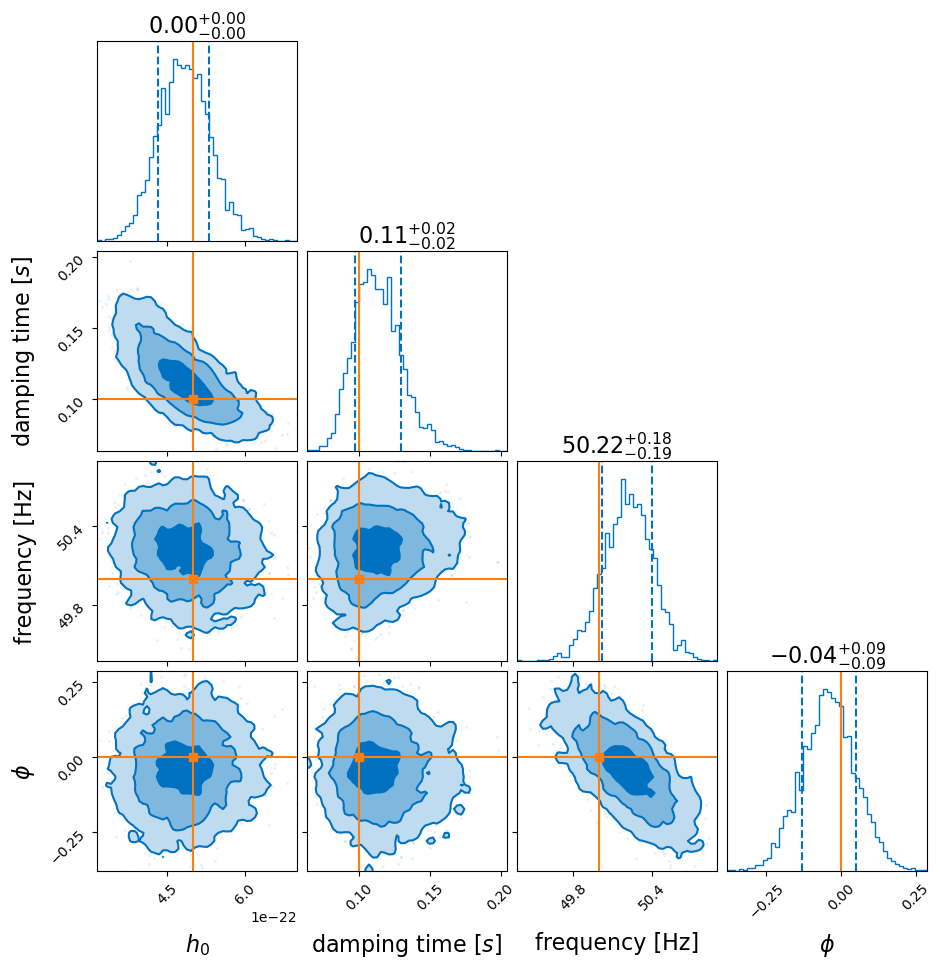

In [14]:
result.plot_corner()

In [29]:
def time_domain_model(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Time Domain Model for the inspiral phase """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 40.0)
#    maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 0.0)
    
    waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
         phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    
    minimum_time = time_array[0]
    maximum_time = time_array[-1]
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)

    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    delta_time = time_array[1] - time_array[0]
    time_bounds = ((time_array >= minimum_time) *
                        (time_array <= maximum_time))
    

    hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',#'SpinTaylorT4',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase,  delta_t = delta_time,
            f_lower = start_frequency, f_ref=reference_frequency,
            **waveform_dictionary)

    h_plus = np.zeros_like(time_array, dtype=complex)
    h_cross = np.zeros_like(time_array, dtype=complex)


    if len(hplus.data.data) > len(time_array):

        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]

        
    else:
        h_plus[-len(hplus.data.data):] = hplus.data.data
        h_cross[-len(hcross.data.data):] = hcross.data.data

    h_plus *= time_bounds
    h_cross *= time_bounds
    
    tindex = np.argmax(h_plus)
    zeros_length = len(h_plus[tindex:])
    
    h_plus = h_plus[:tindex]
    h_cross = h_cross[:tindex]
    
    h_plus = np.concatenate((np.zeros(zeros_length), h_plus))
    h_cross = np.concatenate((np.zeros(zeros_length), h_cross))
    



    return dict(plus=h_plus, cross=h_cross)

/cvmfs/oasis.opensciencegrid.org/ligo/sw/conda/envs/igwn-py39-20220827/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1333: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


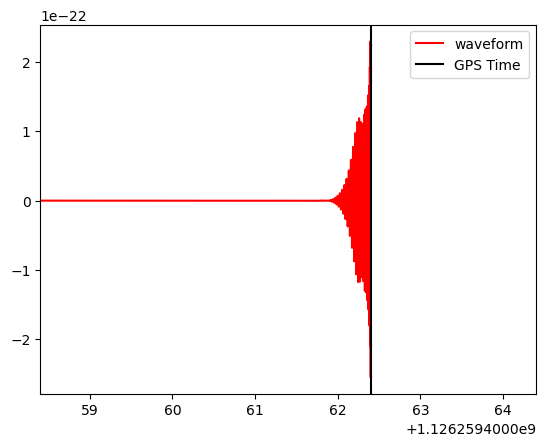

In [32]:
tg = 1126259462.4
t = np.arange(tg-16,tg,1/2048)
model = time_domain_model(t, 20, 30, 2000, 0.3, 0.2,
         a_1=0.3, a_2=0.4, tilt_1=0.0, tilt_2=0.0, phi_12=0.0, phi_jl=0.0)['plus']

plt.plot(t,model,color='r',label='waveform')
plt.xlim([tg-4,tg+2])

plt.axvline(tg,color='k',label='GPS Time')
plt.legend()
plt.show()

In [36]:
hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',
            mass1=30, mass2=20, a_1 = 0.1, a_2 = 0.3,  delta_t = 1/1000,
            f_lower = 20, f_ref=50)

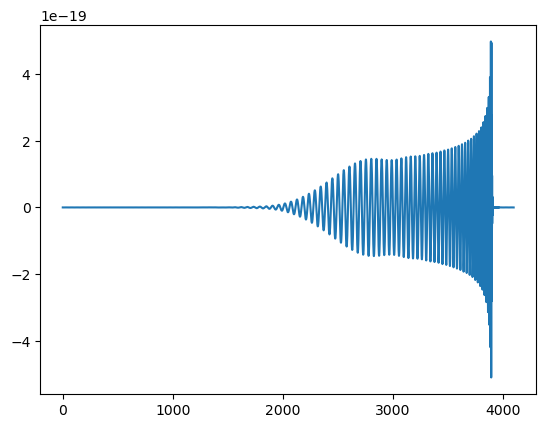

In [37]:
plt.plot(hplus)

In [ ]:
def time_domain_model(time_array, mass_1, mass_2, luminosity_distance, theta_jn, phase,
         a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, 
         **waveform_kwargs):
    """ Time Domain Model for the inspiral phase """
    
    start_frequency = minimum_frequency = waveform_kwargs.get('minimum_frequency', 40.0)
#    maximum_frequency = waveform_kwargs.get('maximum_frequency', frequency_array[-1])
    reference_frequency = waveform_kwargs.get('reference_frequency', 50.0)
    
#     waveform_dictionary = dict(spin_order=-1, tidal_order=-1,
#         phase_order=-1, amplitude_order=0)
    
    m1 = mass_1 * bilby.core.utils.solar_mass
    m2 = mass_2 * bilby.core.utils.solar_mass
    
    minimum_time = time_array[0]
    maximum_time = time_array[-1]
    
    iota, spin_1x, spin_1y, spin_1z, spin_2x, spin_2y, spin_2z = bilby.gw.conversion.bilby_to_lalsimulation_spins(
        theta_jn=theta_jn, phi_jl=phi_jl, tilt_1=tilt_1, tilt_2=tilt_2,
        phi_12=phi_12, a_1=a_1, a_2=a_2, mass_1=m1, mass_2=m2,
        reference_frequency=reference_frequency, phase=phase)

    longitude_ascending_nodes = 0.0
    mean_per_ano = 0.0
    
    delta_time = time_array[1] - time_array[0]
    time_bounds = ((time_array >= minimum_time) *
                        (time_array <= maximum_time))
    

    hplus, hcross = pycbc_wf.get_td_waveform( approximant = 'IMRPhenomPv2',
            mass1=mass_1, mass2=mass_2, spin1x=spin_1x,  spin1y=spin_1y, spin1z=spin_1z, 
            spin2x=spin_2x, spin2y=spin_2y, spin2z=spin_2z, distance=luminosity_distance, 
            inclination=iota, coa_phase=phase,  delta_t = delta_time,
            f_lower = start_frequency, f_ref=reference_frequency)
            #**waveform_dictionary)

    h_plus = np.zeros_like(time_array, dtype=complex)
    h_cross = np.zeros_like(time_array, dtype=complex)


    if len(hplus.data.data) > len(time_array):

        h_plus = hplus.data.data[:len(h_plus)]
        h_cross = hcross.data.data[:len(h_cross)]

        
    else:
        h_plus[-len(hplus.data.data):] = hplus.data.data
        h_cross[-len(hcross.data.data):] = hcross.data.data

    h_plus *= time_bounds
    h_cross *= time_bounds
    
    tindex = np.argmax(h_plus)
    zeros_length = len(h_plus[tindex:])
    
    h_plus = h_plus[:tindex]
    h_cross = h_cross[:tindex]
    
    h_plus = np.concatenate((np.zeros(zeros_length), h_plus))
    h_cross = np.concatenate((np.zeros(zeros_length), h_cross))
    



    return dict(plus=h_plus, cross=h_cross)